## Definations 

In [1]:
import numpy as np
import re
from glob import glob
import pandas as pd
import pickle
import os
import re
import matplotlib.pyplot as plt

Mammo_utils has a lot of useful functions which will help in reading pgm images and slice them. 

In [1]:
from mammo_utils import remove_white_from_image, slice_normal_image, create_slices, read_pgm, get_roi_edges, get_fuzzy_offset, get_roi_edges, random_flip_image, progress, extract_slice
%matplotlib inline

In [5]:
files = sorted(glob('all-mias/*.pgm')) # Gets file name of all the images 
data = [] # to store image 
for file in files:
    data.append(read_pgm(file) * 1.0) # read each file in and convert it to a float
    
images = np.array(data, dtype=np.int16)
# save the images to an npy file so they don't need to be read in individually in the future
np.save(os.path.join('data','images.npy'), images)

In [6]:
# import and clean the annotation data
all_cases_df = pd.read_table('data/Info.txt',delimiter=' ')
all_cases_df.head(20)

,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS
0,mdb001,G,CIRC,B,535,425,197.0
1,mdb002,G,CIRC,B,522,280,69.0
2,mdb003,D,NORM,NaN,NaN,NaN,NaN
3,mdb004,D,NORM,NaN,NaN,NaN,NaN
4,mdb005,F,CIRC,B,477,133,30.0
5,mdb005,F,CIRC,B,500,168,26.0
6,mdb006,F,NORM,NaN,NaN,NaN,NaN
7,mdb007,G,NORM,NaN,NaN,NaN,NaN
8,mdb008,G,NORM,NaN,NaN,NaN,NaN
9,mdb009,F,NORM,NaN,NaN,NaN,NaN


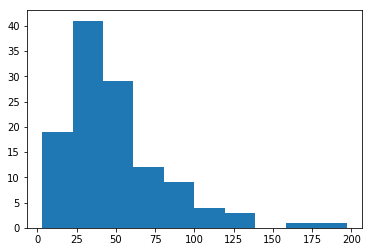

In [7]:
## Look at the sizes of radii
radii = all_cases_df.RADIUS
radii.dropna(inplace=True)
plt.hist(radii)
plt.show()

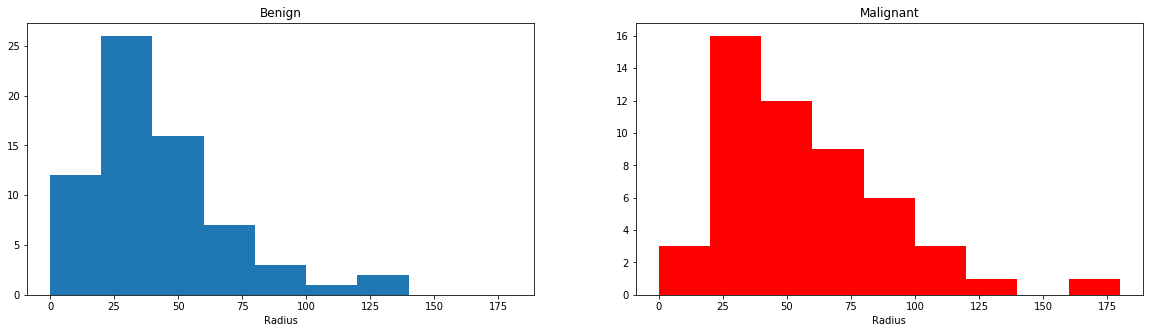

In [8]:
## Look at radii by severity
sev_radii = all_cases_df.loc[:,['RADIUS','SEVERITY']]
sev_radii.dropna(axis=0, how='any', inplace=True)
benign = sev_radii[sev_radii.SEVERITY == 'B']
malignant = sev_radii[sev_radii.SEVERITY == 'M']
f, ax = plt.subplots(1,2,figsize=(20,5))
ax[0].hist(benign.RADIUS, bins=range(0,200,20))
ax[0].set_xlabel("Radius")
ax[0].set_title("Benign")
ax[1].hist(malignant.RADIUS, color="red",  bins=range(0,200,20))
ax[1].set_title("Malignant")
ax[1].set_xlabel("Radius")
plt.show()

In [9]:
# draw image with location of center of abnormality
def draw_image(idx):
    
    
    # account for horizontal flip of some images
    if idx % 2 == 0:
        plt.imshow(np.fliplr((read_pgm(sorted(glob('all-mias/*.pgm'))[idx]))))
        x_loc = 1024 - int(all_cases_df.X[idx])
        
    else:
        plt.imshow(read_pgm(sorted(glob('all-mias/*.pgm'))[idx]))
        x_loc = int(all_cases_df.X[idx])
    plt.plot([x_loc],[1024-int(all_cases_df.Y[idx])], 'ro')
    radius = str(all_cases_df.RADIUS[idx])
    print([x_loc],[1024-int(all_cases_df.Y[idx])])
    plt.title("Radius:" + radius)
    plt.show()

[489] [599]


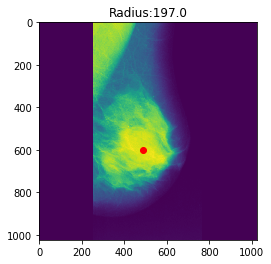

In [10]:
draw_image(0)

In [11]:
all_cases_df = all_cases_df.dropna(subset=['SEVERITY','X','Y','RADIUS'])

In [12]:
all_cases_df.shape

(119, 7)

In [13]:
all_cases_df['path'] = all_cases_df['REFNUM'].map(lambda x: '%s.pgm' % x)

In [14]:
all_cases_df.head(20)

,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS,path
0,mdb001,G,CIRC,B,535,425,197.0,mdb001.pgm
1,mdb002,G,CIRC,B,522,280,69.0,mdb002.pgm
4,mdb005,F,CIRC,B,477,133,30.0,mdb005.pgm
5,mdb005,F,CIRC,B,500,168,26.0,mdb005.pgm
10,mdb010,F,CIRC,B,525,425,33.0,mdb010.pgm
12,mdb012,F,CIRC,B,471,458,40.0,mdb012.pgm
13,mdb013,G,MISC,B,667,365,31.0,mdb013.pgm
15,mdb015,G,CIRC,B,595,864,68.0,mdb015.pgm
17,mdb017,G,CIRC,B,547,573,48.0,mdb017.pgm
19,mdb019,G,CIRC,B,653,477,49.0,mdb019.pgm


# SECTION TWO FOR THE DATA SLICING

In [16]:
# remember there are no NAN left in the SEVERITY COLUMN

def get_image_class(df, idx):
     # get the name of the image from the data
    img_name = df.loc[idx]['path']
    severity = df.loc[idx]['SEVERITY']
    img_class = df.loc[idx]['CLASS']
    
    if severity == "M":
        img_label = "MALIGNANT_"
        if img_class == "CALC":
            img_label = img_label + "calcification"
        else:
            img_label = img_label + "mass"
            
    else:
        img_label = "BENIGN_"
        if img_class == "CALC":
            img_label = img_label + "calcification"
        else:
            img_label = img_label + "mass"
    
    return img_label

In [17]:
def trim_image_margins(img):
    img_h = img.shape[0]
    img_w = img.shape[1]
    
    # get which columns are all black
    black_pixels = np.sum(img == 0, axis=0)
    
    blank_cols = (black_pixels >= (img_h - 10))
    
    # first trim from the left
    first_col = np.argmax(~blank_cols)
    
    # now trim from the right
    last_col = img_w - np.argmax(~np.flip(blank_cols, axis=0))
    #last_col = 0
    
    img = img[:,first_col:last_col]
    
    return img, first_col, last_col

In [18]:
def get_random_scale(scale_by):
    # get the random factor
    random_scale_by = np.random.normal(loc=scale_by, scale=(scale_by * 0.4), size=None)
    
    # if the scale by is within a range return it, else keep trying until it is within the range
    if (random_scale_by > 1.5) and (random_scale_by < 2.75):
        return random_scale_by
    else:
        return get_random_scale(scale_by)


In [57]:
## Copy of function used to crop cbis images, but altered to deal with MIAS images
## returns: numpy array of images and list of corresponding file names
def create_mias_slices(df, pgm_dir="all-mias/", scale_by=2.2, slice_size=299, 
                       var_upper_threshold=2000, var_lower_threshold=20, mean_threshold=38, 
                       debug=None):
    # loop through rows in the data frame
    slices_list = [] 
    image_names_list = []
    labels_list = []
    full_slice_size = slice_size
    
    counter = 0
    if debug is None: # Just to show the Progress 
        progress(counter, len(df), 'WORKING')
    
    for index, row in df.iterrows(): # Run for the rows in the data 
        
        # get the base file name from the mask name
        image_name = row['path']
        
        # create a progress bar
        counter += 1
        if debug is None:
            progress(counter,  len(df), image_name)
            
        # try to open the image, if it doesn't exist continue
        try:
            full_image_arr = read_pgm('all-mias/' +  image_name)
        except:
            print(image_name, "file not found!")
            continue             

        # get the shape of the image
        image_h, image_w = full_image_arr.shape
            
        # get the class of the image
        image_class = get_image_class(df, index)
        if debug is True:
            print(image_name, image_class, "abnormal")           
            
            # get the size and shape of the ROI, NOT offset by the number of columns trimmed off
            center_col = int(row['X'])# * scale_by)
            center_row = image_h - int(row['Y'])# * scale_by)

            # the ROI is square so we don't need to get the sizes individually
            roi_size = mask_height = mask_width = mask_size = row['RADIUS'] * scale_by

            #####################################################################################
            ## extract the ROI with context size equal to double ROI size and random augmentation
            if debug:
                print("Adding ROI at size", image_name)

            img_slice = extract_slice(full_image_arr, center_col, center_row, roi_size, padding=1.2, context_scale=2, return_slice_size=299, distort=False)

            if img_slice.shape == (299,299, 1):
                slices_list.append(img_slice)
                image_names_list.append(image_name)
                labels_list.append(image_class)

            ####################################################################################
            ## Extract the ROI with a smaller margins
            img_slice = extract_slice(full_image_arr, center_col, center_row, roi_size, padding=1.3, context_scale=1.5, return_slice_size=299, distort=False)

            if img_slice.shape == (299,299, 1):
                slices_list.append(img_slice)
                image_names_list.append(image_name)
                labels_list.append(image_class)

                # if the slice is the right shape add it to the list
                print(img_slice.shape)
                

    return np.array(slices_list), np.array(labels_list), image_names_list

In [58]:
# import and clean the annotation data, this time leave the duplicates
all_cases_df = pd.read_table('data/Info.txt', delimiter=' ')
all_cases_df['path'] = all_cases_df['REFNUM'].map(lambda x: '%s.pgm' % x)
all_cases_df = all_cases_df.dropna(subset=['SEVERITY','X','Y','RADIUS'])

In [59]:
all_cases_df.shape

(119, 8)

In [60]:
slices, labels, filenames = create_mias_slices(all_cases_df, debug=True)

mdb001.pgm BENIGN_mass abnormal
Adding ROI at size mdb001.pgm
(299, 299, 1)
mdb002.pgm BENIGN_mass abnormal
Adding ROI at size mdb002.pgm
(299, 299, 1)
mdb005.pgm BENIGN_mass abnormal
Adding ROI at size mdb005.pgm
(299, 299, 1)
mdb005.pgm BENIGN_mass abnormal
Adding ROI at size mdb005.pgm
(299, 299, 1)
mdb010.pgm BENIGN_mass abnormal
Adding ROI at size mdb010.pgm
(299, 299, 1)
mdb012.pgm BENIGN_mass abnormal
Adding ROI at size mdb012.pgm
(299, 299, 1)
mdb013.pgm BENIGN_mass abnormal
Adding ROI at size mdb013.pgm
(299, 299, 1)
mdb015.pgm BENIGN_mass abnormal
Adding ROI at size mdb015.pgm
(299, 299, 1)
mdb017.pgm BENIGN_mass abnormal
Adding ROI at size mdb017.pgm
(299, 299, 1)
mdb019.pgm BENIGN_mass abnormal
Adding ROI at size mdb019.pgm
(299, 299, 1)
mdb021.pgm BENIGN_mass abnormal
Adding ROI at size mdb021.pgm
(299, 299, 1)
mdb023.pgm MALIGNANT_mass abnormal
Adding ROI at size mdb023.pgm
(299, 299, 1)
mdb025.pgm BENIGN_mass abnormal
Adding ROI at size mdb025.pgm
(299, 299, 1)
mdb028.pg

(299, 299, 1)
mdb249.pgm MALIGNANT_calcification abnormal
Adding ROI at size mdb249.pgm
(299, 299, 1)
mdb249.pgm MALIGNANT_calcification abnormal
Adding ROI at size mdb249.pgm
(299, 299, 1)
mdb252.pgm BENIGN_calcification abnormal
Adding ROI at size mdb252.pgm
(299, 299, 1)
mdb253.pgm MALIGNANT_calcification abnormal
Adding ROI at size mdb253.pgm
(299, 299, 1)
mdb256.pgm MALIGNANT_calcification abnormal
Adding ROI at size mdb256.pgm
(299, 299, 1)
mdb264.pgm MALIGNANT_mass abnormal
Adding ROI at size mdb264.pgm
(299, 299, 1)
mdb265.pgm MALIGNANT_mass abnormal
Adding ROI at size mdb265.pgm
(299, 299, 1)
mdb267.pgm MALIGNANT_mass abnormal
Adding ROI at size mdb267.pgm
(299, 299, 1)
mdb270.pgm MALIGNANT_mass abnormal
Adding ROI at size mdb270.pgm
(299, 299, 1)
mdb271.pgm MALIGNANT_mass abnormal
Adding ROI at size mdb271.pgm
(299, 299, 1)
mdb274.pgm MALIGNANT_mass abnormal
Adding ROI at size mdb274.pgm
(299, 299, 1)
mdb290.pgm BENIGN_mass abnormal
Adding ROI at size mdb290.pgm
(299, 299, 1)

In [56]:
print("Slices:", slices.shape)
print("Labels:", labels.shape)
print("Filenames:", len(filenames))

Slices: (238, 299, 299, 1)
Labels: (238,)
Filenames: 238


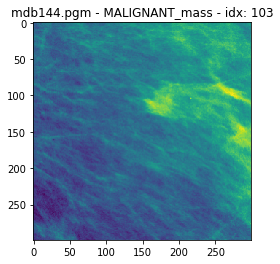

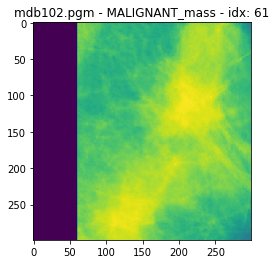

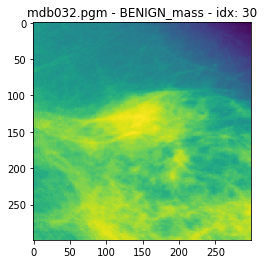

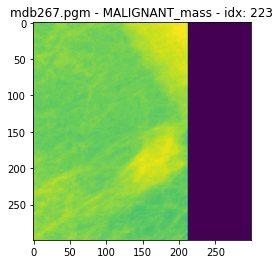

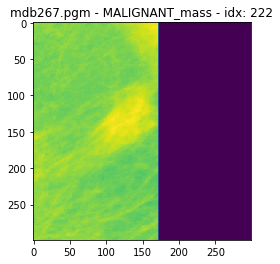

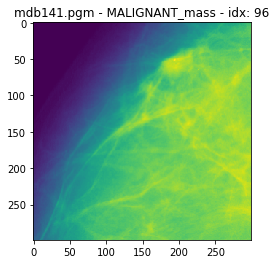

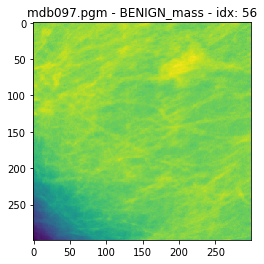

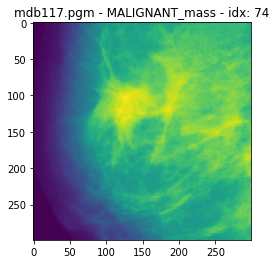

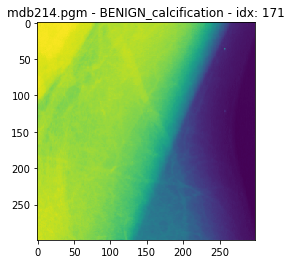

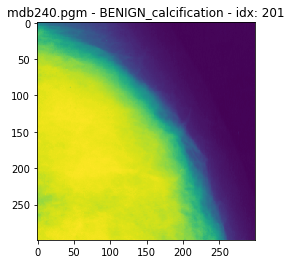

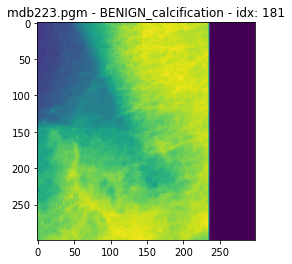

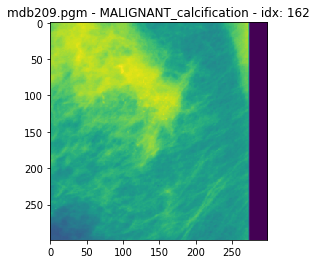

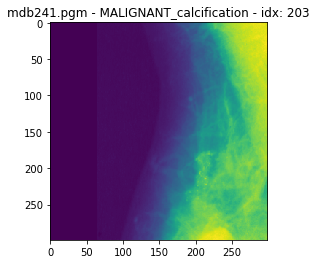

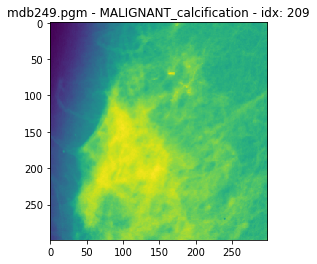

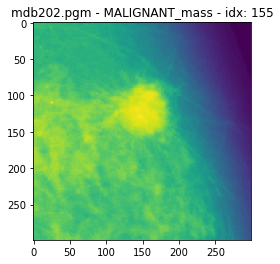

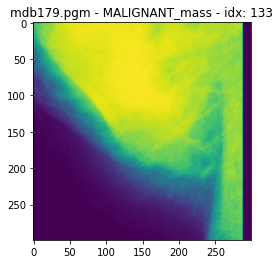

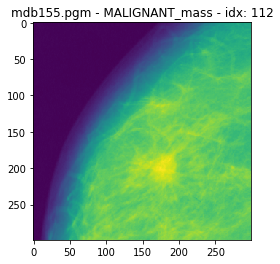

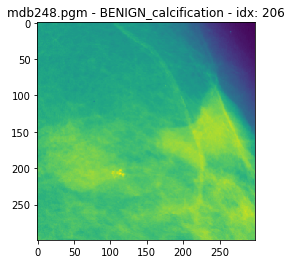

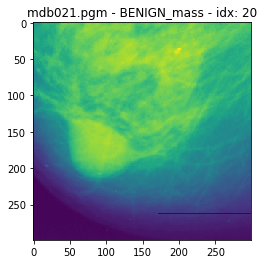

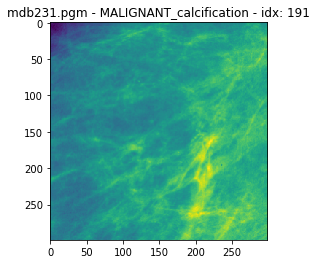

In [62]:
# look at some random images
import random
N = 20
idxs = random.sample(range(len(slices)), k=N)

for idx in idxs:
    plt.imshow(slices[idx].reshape(299,299))
    plt.title(filenames[idx] + " - " + labels[idx] + " - idx: " + str(idx))
    plt.show()



In [63]:
pd.value_counts(labels, normalize=True)

BENIGN_mass                0.445378
MALIGNANT_mass             0.327731
BENIGN_calcification       0.126050
MALIGNANT_calcification    0.100840
dtype: float64

In [64]:
# encode the labels
from sklearn import preprocessing

In [65]:
# create the encoder
le = preprocessing.LabelEncoder()
le.fit(labels)


LabelEncoder()

In [68]:
labels_enc = le.transform(labels) + 1

In [69]:
labels_enc

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       4, 4, 2, 2, 4, 4, 2, 2, 2, 2, 4, 4, 2, 2, 2, 2, 4, 4, 4, 4, 2, 2,
       2, 2, 2, 2, 4, 4, 2, 2, 4, 4, 4, 4, 2, 2, 2, 2, 4, 4, 2, 2, 4, 4,
       2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 4, 4, 4, 4, 2, 2, 2, 2,
       4, 4, 2, 2, 2, 2, 4, 4, 4, 4, 2, 2, 2, 2, 4, 4, 2, 2, 4, 4, 2, 2,
       2, 2, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 2, 2, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       4, 4, 2, 2, 4, 4, 2, 2, 3, 3, 3, 3, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 3, 3, 3, 3,
       3, 3, 1, 1, 3, 3, 2, 2, 1, 1, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2])

In [70]:
mias_classes = le.classes_

In [71]:
mias_classes

array(['BENIGN_calcification', 'BENIGN_mass', 'MALIGNANT_calcification',
       'MALIGNANT_mass'], dtype='<U23')

In [72]:
## save the data
np.save(os.path.join("data", "all_mias_slices.npy"), slices)
np.save(os.path.join("data", "all_mias_labels.npy"), labels_enc)
np.save(os.path.join("data", "all_mias_filenames.npy"), filenames)

# TIME FOR DIVIDING DATA

In [73]:
all_normal_images = np.load(os.path.join("data", "all_mias_slices.npy"))

In [74]:
all_normal_labels = np.load(os.path.join("data", "all_mias_labels.npy"))

In [75]:
normal_filenames = np.load(os.path.join("data", "all_mias_filenames.npy"))

In [80]:
from sklearn.model_selection import train_test_split

# now shuffle and split the images 
split_train_normal_images, split_test_normal_images, split_train_normal_labels, split_test_normal_labels, split_train_normal_filenames, split_test_normal_filenames  = train_test_split(all_normal_images, 
all_normal_labels, normal_filenames, test_size=0.1)

In [81]:
print(split_train_normal_images.shape, split_test_normal_images.shape, split_train_normal_labels.shape, split_test_normal_labels.shape, split_train_normal_filenames.shape, split_test_normal_filenames.shape)

(214, 299, 299, 1) (24, 299, 299, 1) (214,) (24,) (214,) (24,)


In [83]:
split_test_normal_labels

array([4, 3, 2, 3, 2, 2, 1, 2, 2, 1, 1, 3, 2, 4, 2, 1, 4, 3, 1, 2, 4, 3,
       2, 3])

In [103]:
np.save(os.path.join("data", "all_mias_slices_train.npy"), split_train_normal_images)
np.save(os.path.join("data", "all_mias_labels_train.npy"), split_train_normal_labels)
np.save(os.path.join("data", "all_mias_filenames_train.npy"), split_train_normal_filenames)

np.save(os.path.join("data", "all_mias_slices_test.npy"), split_test_normal_images)
np.save(os.path.join("data", "all_mias_labels_test.npy"), split_test_normal_labels)
np.save(os.path.join("data", "all_mias_filenames_test.npy"), split_test_normal_filenames)

In [104]:
image = np.load(os.path.join("data", "all_mias_slices_train.npy"))

In [105]:
image.shape

(214, 299, 299, 1)